In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# Create engine to connect to the database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables from the database
Base.prepare(engine, reflect=True)


/var/folders/7p/2bq78wp5647fttblw3mr2v000000gn/T/ipykernel_17737/1169413202.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [39]:
# Find the most recent date in the data set
latest_date = session.query(func.max(Measurement.date)).scalar()
print(latest_date)


2017-08-23


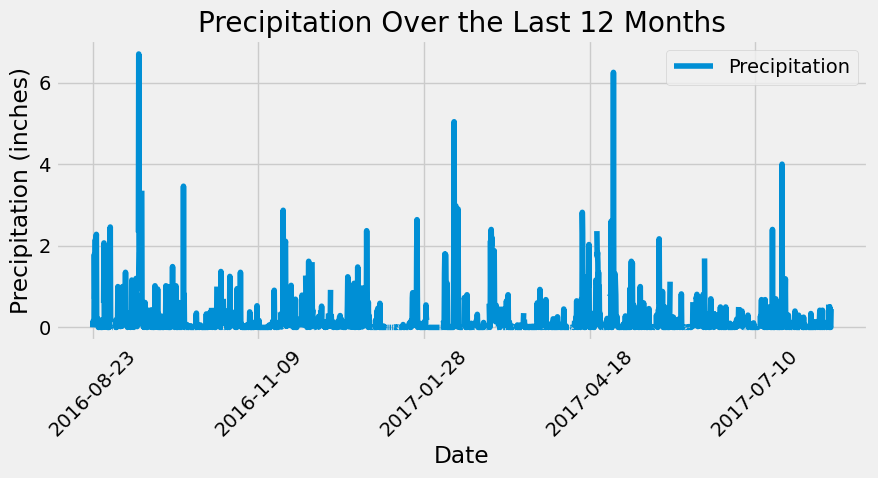

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the Date One Year Ago
one_year_ago = dt.date.fromisoformat(latest_date) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
                            .filter(Measurement.date >= one_year_ago)\
                            .order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='Date', y='Precipitation', figsize=(9, 5))
plt.title("Precipitation Over the Last 12 Months")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [34]:
# Use Pandas to calculate summary statistics for the precipitation data
summary_statistics = precipitation_df['Precipitation'].describe()

# Format the summary statistics as a table-like string
summary_statistics_table = (
    "Precipitation:\n"
    f"{'count':<10}{summary_statistics['count']:>10.6f}\n"
    f"{'mean':<10}{summary_statistics['mean']:>10.6f}\n"
    f"{'std':<10}{summary_statistics['std']:>10.6f}\n"
    f"{'min':<10}{summary_statistics['min']:>10.6f}\n"
    f"{'25%':<10}{summary_statistics['25%']:>10.6f}\n"
    f"{'50%':<10}{summary_statistics['50%']:>10.6f}\n"
    f"{'75%':<10}{summary_statistics['75%']:>10.6f}\n"
    f"{'max':<10}{summary_statistics['max']:>10.6f}"
)

# Print the formatted summary statistics table
print(summary_statistics_table)


Precipitation:
count     2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [40]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(total_stations)


9


In [36]:
# Design a query to find the most active stations
most_active_stations = session.query(Measurement.station, func.count(Measurement.station))\
                              .group_by(Measurement.station)\
                              .order_by(func.count(Measurement.station).desc())\
                              .all()

# Print the most active stations and their counts in descending order
print
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [37]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Extract the most active station ID from the previous query
most_active_station_id = most_active_stations[0][0]

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
                          .filter(Measurement.station == most_active_station_id)\
                          .all()

# Extract the results
lowest_temp, highest_temp, avg_temp = temperature_stats[0]

# Print the results
print(f"Lowest Temperature: {lowest_temp} °F")
print(f"Highest Temperature: {highest_temp} °F")
print(f"Average Temperature: {avg_temp:.2f} °F")


Lowest Temperature: 54.0 °F
Highest Temperature: 85.0 °F
Average Temperature: 71.66 °F


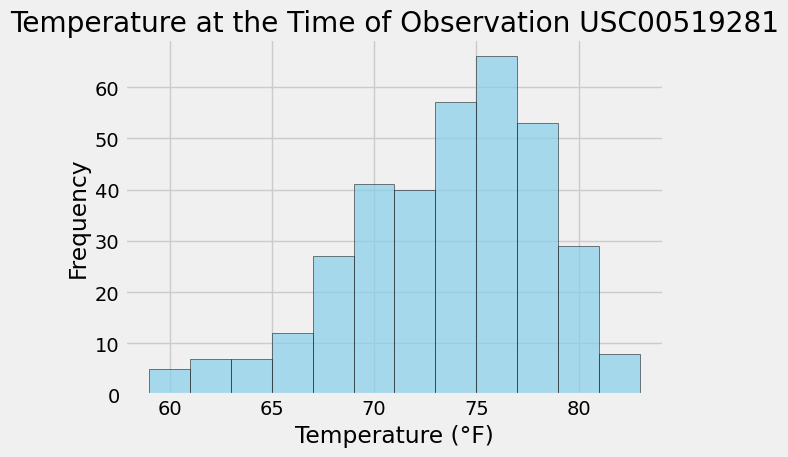

In [38]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Calculate the date one year ago
one_year_ago = dt.date.fromisoformat(latest_date) - dt.timedelta(days=365)

# Query the temperature observations for the most active station within the last 12 months
temperature_data = session.query(Measurement.tobs)\
                          .filter(Measurement.station == most_active_station_id)\
                          .filter(Measurement.date >= one_year_ago)\
                          .all()

# Save the query results as a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['Temperature'])

# Plot the histogram of temperature observations
plt.hist(temperature_df['Temperature'], bins=12, color='skyblue', edgecolor='black', alpha=0.7)
plt.title(f'Temperature at the Time of Observation {most_active_station_id}')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()